## test+train的Fat data全用來當word2vec的訓練文本
## 不考慮出現"not"的情況( "not" 在model中相關字的意思和"not"沒有太大相關性)

In [1]:
from os import listdir
from os.path import isfile, isdir, join
from collections import Counter
import csv
import numpy
import pandas as pd
from gensim.models.word2vec import Word2Vec
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from data_preprocess import content_fraction
from Dataloader import dataloader

In [2]:
train_data_path = "..\Case_Presentation_1_Data\Train_Textual\\"
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"

train_data = dataloader(train_data_path)
test_data  = dataloader(test_data_path)

In [3]:
print(train_data.text_list[0])

['discharg', 'summari', 'unsign', 'admiss', 'date', 'report', 'statu', 'unsign', 'discharg', 'date', 'discharg', 'diagnosi', 'coronari', 'arteri', 'diseas', 'unstabl', 'angina', 'histori', 'present', 'ill', 'hoopl', 'old', 'woman', 'statu', 'post', 'doubl', 'coronari', 'arteri', 'bypass', 'graft', 'endarterectomi', 'fourteen', 'year', 'ago', 'develop', 'angina', 'six', 'month', 'ago', 'suffer', 'unstabl', 'angina', 'sever', 'day', 'coronari', 'catheter', 'result', 'show', 'sever', 'occlus', 'saphen', 'vein', 'graft', 'occlus', 'left', 'anterior', 'descend', 'echocardiogram', 'show', 'excel', 'left', 'ventricular', 'function', 'intraaort', 'balloon', 'pump', 'place', 'reliev', 'intract', 'angina', 'past', 'medic', 'histori', 'signific', 'chest', 'pain', 'short', 'breath', 'admit', 'talc', 'commun', 'medic', 'center', 'catheter', 'coronari', 'arteri', 'bypass', 'graft', 'coronari', 'endarterectomi', 'no', 'chest', 'pain', 'six', 'month', 'prior', 'admiss', 'time', 'inder', 'aspirin', 'si

### 取train data和test data中"非肥胖"的text

In [4]:
model = Word2Vec(test_data.text_list[200:400])

In [5]:
#定義相關性
def similar(w2v_model, word, target, topn=10):
        try:
            return w2v_model.wv.similarity(word, target)
        except:
            return 0

In [6]:
#找和 words相關性最大的前 [topn] 個字
def most_similar(w2v_model, words, topn=20):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

### 和"not"相關的前幾個字和"not"本身文義不相關

In [7]:
print(most_similar(model, ["not"]))

                   not       cos
0                 none  0.913286
1   treatmentsprocedur  0.909145
2               detail  0.895364
3             procedur  0.891125
4                brief  0.877484
5                 oper  0.876307
6               cather  0.874140
7               suicid  0.864387
8              remaind  0.861863
9              rouxeni  0.844363
10              commun  0.839404
11             uncompl  0.838934
12          laparoscop  0.831595
13                want  0.829425
14              hospit  0.829098
15               cours  0.825202
16        tracheostomi  0.824850
17         colonoscopi  0.820468
18               evalu  0.820358
19             surgeri  0.817162


In [8]:
print(most_similar(model, ["hypercholesterolemia"]))

   hypercholesterolemia       cos
0                reflux  0.994232
1                  gout  0.993230
2         gastroesophag  0.992466
3        hyperlipidemia  0.992353
4                   osa  0.990562
5                anemia  0.990107
6                peptic  0.990077
7               depress  0.987626
8                asthma  0.987599
9                  iddm  0.987444
10                stent  0.986494
11                 copd  0.985760
12               mother  0.985729
13               vessel  0.985558
14                 cabg  0.984474
15                adult  0.983342
16         dyslipidemia  0.982554
17           osteoarthr  0.982461
18             idiopath  0.981412
19          hypothyroid  0.981113


In [9]:
print(most_similar(model, ["angina"]))

            angina       cos
0          unstabl  0.993643
1            chief  0.988790
2             copd  0.988000
3          infarct  0.987688
4         myocardi  0.987238
5             cabg  0.985353
6          exacerb  0.984051
7            viral  0.982385
8           recent  0.982041
9            stent  0.980777
10     angioplasti  0.980526
11       cholecyst  0.980222
12       secondari  0.979501
13          cellul  0.979309
14          stroke  0.979307
15    appendectomi  0.978808
16  cardiomyopathi  0.978500
17            like  0.978498
18       bronchiti  0.978143
19           flare  0.978036


---------------------------------------------------------------------------------------------------------------------------

## 計分方式

In [10]:
def score(datakind, gap, target_word):
    score=0
    total = 0
    for text in datakind:
        for word in text:
            if similar(model, word,  target_word)>gap:
                score+=similar(model, word, target_word)
        total+=score
        score=0
    average = total/200
    return average

### [gap]定義在大於多少相識性時要承認
### [target_word]定義要以哪個字為中心找相關性

In [11]:
gap = 0.85
target_word = "hypertens"

# Train data

## 不肥胖

In [12]:
train_unfat_score = score(train_data.text_list[0:200], gap, target_word)
print("train_unfat_score: ",train_unfat_score)

train_unfat_score:  44.383666716217995


## 肥胖

In [13]:
train_fat_score = score(train_data.text_list[200:400], gap, target_word)
print("train_fat_score: ",train_fat_score)

train_fat_score:  47.547274655997754


# Test data

## 不肥胖

In [14]:
test_unfat_score = score(test_data.text_list[0:200], gap, target_word)
print("test_unfat_score: ",test_unfat_score)

test_unfat_score:  45.533733414709566


## 肥胖

In [15]:
test_fat_score =score(test_data.text_list[200:400], gap, target_word)
print("test_fat_score: ",test_fat_score)

test_fat_score:  45.91182622998953


In [16]:
upper = (train_fat_score+test_fat_score)/2
print("upper: ",upper)

upper:  46.72955044299364


In [17]:
lower =  (train_unfat_score+test_unfat_score)/2
print("lower: ",lower)

lower:  44.95870006546378


### standard 建立判斷文章是否為Fat 的標準分數。 大於standard即為Fat，反之不是

In [18]:
standard = (upper+lower)/2
print("standard: ",standard)

standard:  45.844125254228715


---------------------------------------------------------------------------------------------------------------------------

# Validation

In [19]:
validation_data_path  = "..\Case_Presentation_1_Data\Validation\\"
validation_data  = dataloader(validation_data_path)

In [20]:
score(validation_data.text_list, gap, target_word)

13.550608313977719

In [21]:
score=0
ans = []
for text in validation_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        ans.append(0)
    else:
        ans.append(1)
    score=0

print(len(ans))

50


In [22]:
print(ans)

[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [23]:
len(validation_data.text_list)

50

---------------------------------------------------------------------------------------------------------------------------

# confusion matrix & F1-score

In [24]:
from sklearn.metrics import confusion_matrix

def precision(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[0,1])

def recall(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[1,0])


def f1(matrix):
    return (2*precision(matrix)*recall(matrix))/(precision(matrix)+recall(matrix))


def confusionMatix(matrix, title):
    sns.set()
    f,ax=plt.subplots()
    #y_true = label
    #y_pred = ans
    sns.heatmap(matrix,annot=True,ax=ax, cmap = plt.cm.Blues) #畫熱力圖

    ax.set_title(title) #標題
    ax.set_xlabel('predict') #x軸
    ax.set_ylabel('true') #y軸

def print_result(matrix, title):
    print("precision: ",precision(matrix))
    print("recall: ",recall(matrix))
    print("F1-Score: ",f1(matrix))
    confusionMatix(matrix, title)
    
        

---------------------------------------------------------------------------------------------------------------------------

## train data

In [25]:
train_data_path  = "..\Case_Presentation_1_Data\Train_Textual\\"
train_data  = dataloader(train_data_path)
score=0
train_ans = []
for text in train_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        train_ans.append(0)
    else:
        train_ans.append(1)
    score=0

In [26]:
train_y_true = train_data.label_list
train_y_pred = train_ans

train_confusion_matrix = confusion_matrix(train_y_true, train_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(train_confusion_matrix[i][j])/200
train_confusion_matrix = tmp

precision:  0.41
recall:  0.4685714285714285
F1-Score:  0.43733333333333324


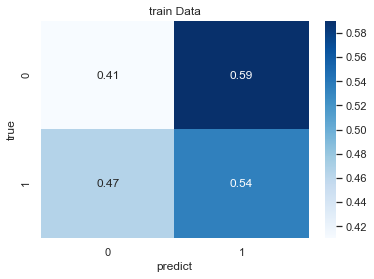

In [27]:
print_result(train_confusion_matrix, "train Data")

## test data

In [28]:
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"
test_data  = dataloader(test_data_path)
score=0
test_ans = []

for text in test_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        test_ans.append(0)
    else:
        test_ans.append(1)
    score=0

In [29]:
test_y_true = test_data.label_list
test_y_pred = test_ans

test_confusion_matrix = confusion_matrix(test_y_true, test_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(test_confusion_matrix[i][j])/200
test_confusion_matrix = tmp

precision:  0.425
recall:  0.4829545454545454
F1-Score:  0.45212765957446804


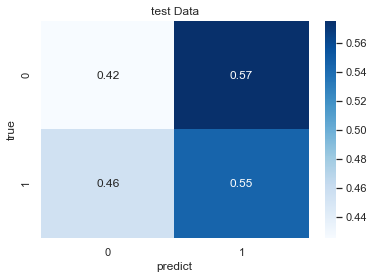

In [30]:
print_result(test_confusion_matrix, "test Data")